In [1]:
# Uncomment this when running in a remote (e.g. Colab) environment
'''
!git clone https://github.com/dominicm00/plsn.git
%cd plsn
%pip install -e .
'''

'\n!git clone https://github.com/dominicm00/plsn.git\n%cd plsn\n%pip install -e .\n'

# PLSN (Plastic Local Sparse Network)

This notebook demonstrates the PLSN architecture with spatially-positioned neurons and distance-based connectivity.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from plsn import NetworkBuilder
from plsn.init import (
    DistanceBasedInitializer,
    FullyConnectedInitializer,
    LatticePositionInitializer,
    RandomPositionInitializer,
)
from plsn.init.distributions import (
    LinearDistanceDistribution,
    GaussianDistanceDistribution,
    ExponentialDistanceDistribution,
    StepDistanceDistribution,
)

## Create a Lattice Network

Build a 4×4 lattice of neurons with linear distance-based connections.

In [3]:
network = (
    NetworkBuilder()
    .with_dimensions(2)
    .with_bands(4)
    .with_model_initializer(
        neurons=16,  # 4x4 grid
        position=LatticePositionInitializer(),
        connections=[DistanceBasedInitializer(LinearDistanceDistribution())],
    )
    .with_seed(42)
    .build()
)

print(network)

LatticeNetwork(neurons=16, dims=2, bands=4, connections=51)


## Visualize the Network

Plot neurons as points and their connections as lines.

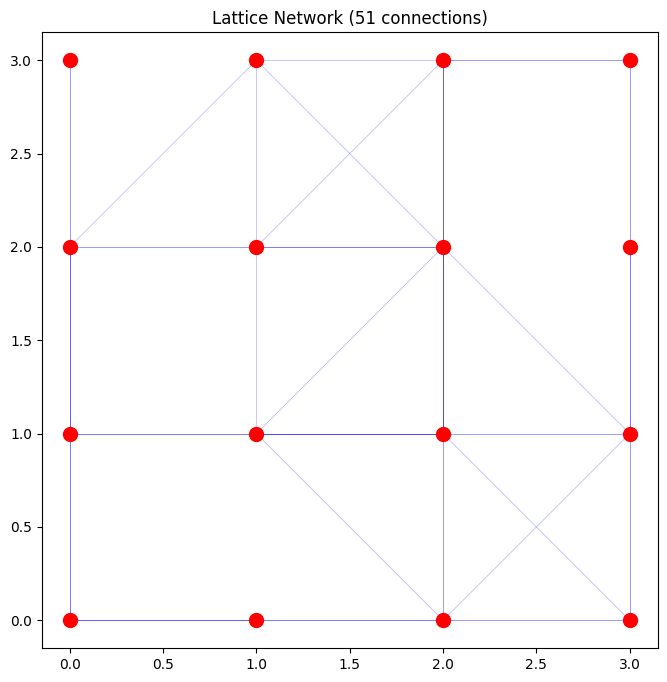

In [4]:
def visualize_network(net, ax=None, title="Lattice Network"):
    """Visualize a 2D lattice network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw connections
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            p1 = net.neurons[i].position
            p2 = net.neurons[j].position
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   'b-', alpha=0.3, linewidth=0.5)
    
    # Draw neurons
    positions = np.array([n.position for n in net.neurons])
    ax.scatter(positions[:, 0], positions[:, 1], 
              s=100, c='red', zorder=5)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    return ax

visualize_network(network, title=f"Lattice Network ({network.connection_count()} connections)")
plt.show()

## Compare Distribution Types

See how different probability distributions affect connectivity patterns.

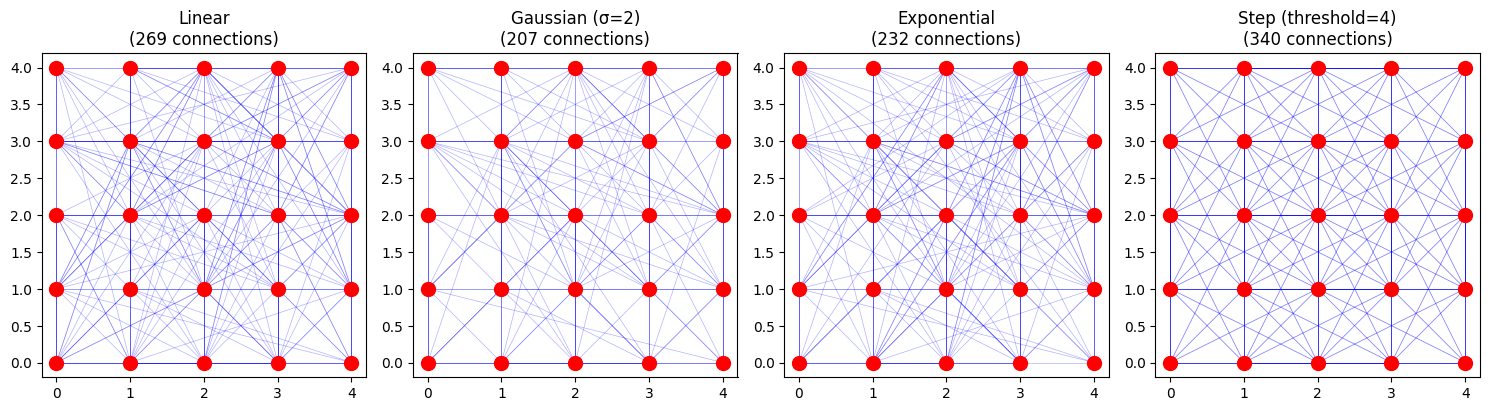

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

distributions = [
    ("Linear", LinearDistanceDistribution(max_distance=6)),
    ("Gaussian (σ=2)", GaussianDistanceDistribution(sigma=2)),
    ("Exponential", ExponentialDistanceDistribution(scale=3)),
    ("Step (threshold=4)", StepDistanceDistribution(threshold=4)),
]

for ax, (name, dist) in zip(axes, distributions):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_model_initializer(
            neurons=25,
            connections=[DistanceBasedInitializer(dist)],
        )
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

# Compare Position Initializers

See how the networks look with different position initializers.

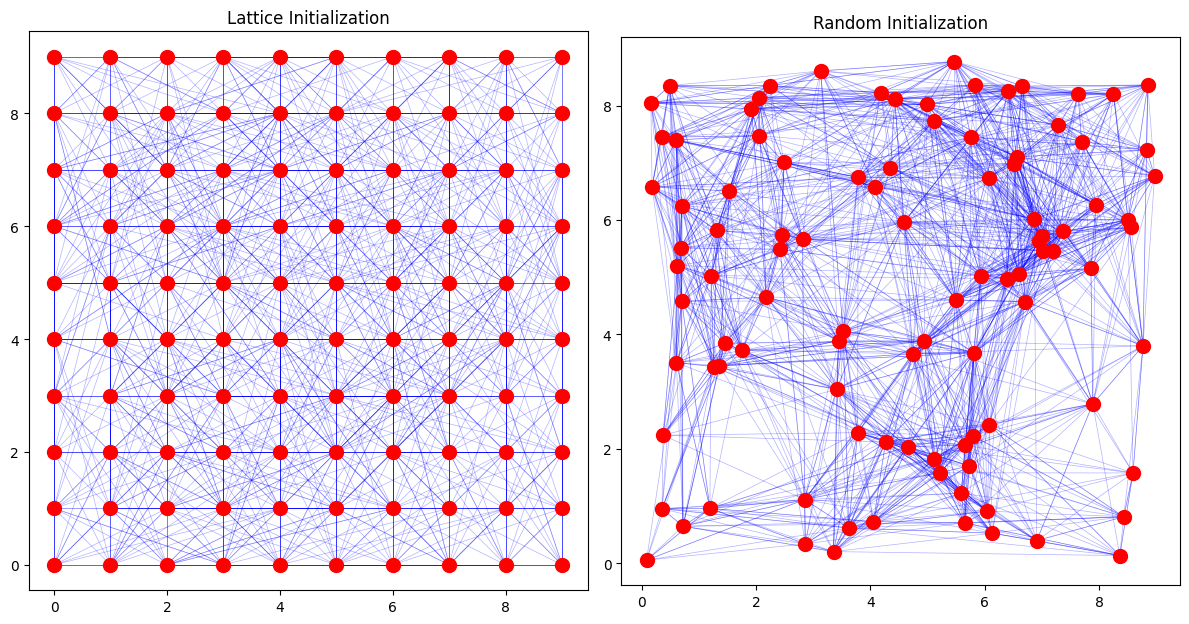

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

initializers = [
    ("Lattice", LatticePositionInitializer()),
    ("Random", RandomPositionInitializer()),
]

for ax, (name, init) in zip(axes, initializers):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_model_initializer(
            neurons=100,
            position=init,
            connections=[DistanceBasedInitializer(LinearDistanceDistribution(max_distance=6))],
        )
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name} Initialization")

plt.tight_layout()
plt.show()

## Global Initializer

The `GlobalInitializer` connects neurons with uniform probability regardless of distance.
This is useful for adding "small-world" long-range connections to locally-connected networks.

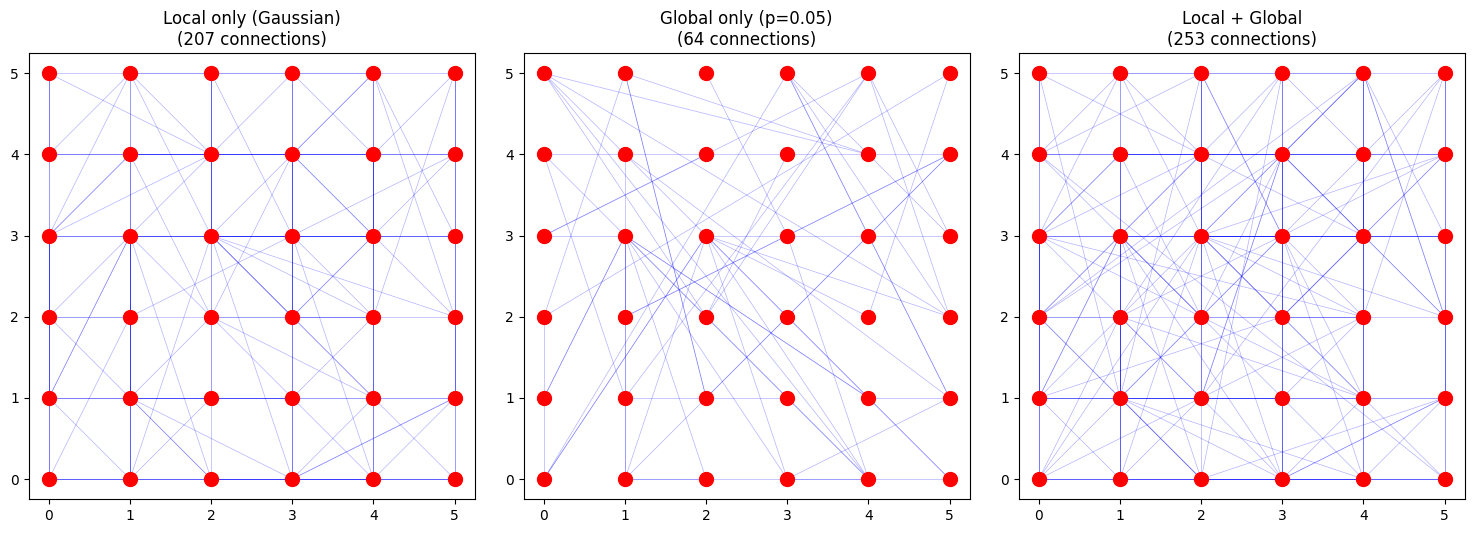

In [7]:
from plsn.init import GlobalInitializer

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

configs = [
    ("Local only (Gaussian)", [DistanceBasedInitializer(GaussianDistanceDistribution(sigma=1.5))]),
    ("Global only (p=0.05)", [GlobalInitializer(probability=0.05)]),
    ("Local + Global", [
        DistanceBasedInitializer(GaussianDistanceDistribution(sigma=1.5)),
        GlobalInitializer(probability=0.05),
    ]),
]

for ax, (name, conn_inits) in zip(axes, configs):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_model_initializer(
            neurons=36,
            connections=conn_inits,
        )
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

## Weight Initialization

The `WeightInitializer` randomly assigns weights to existing connections based on a weight distribution.
This example shows connections color-coded by their weight values.

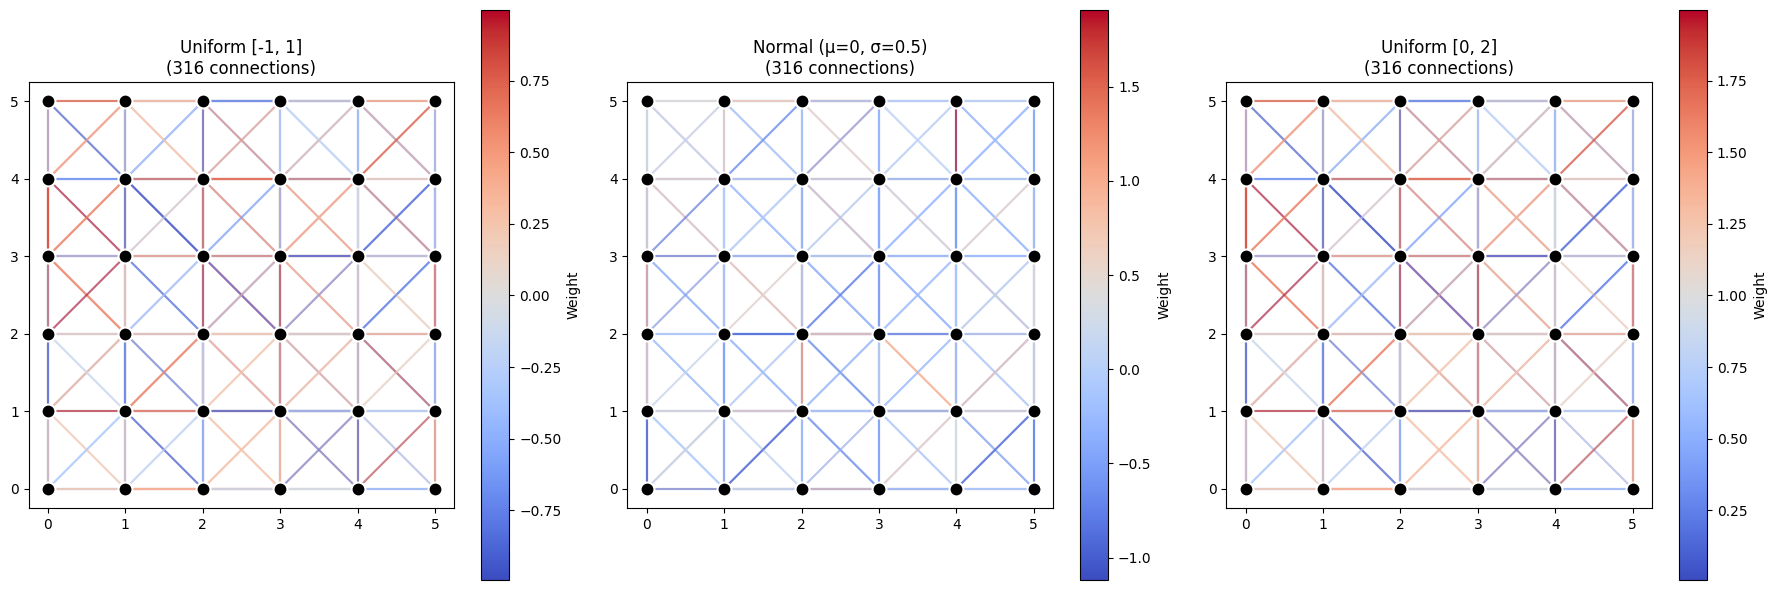

In [8]:
from plsn.init import WeightInitializer
from plsn.init.distributions import (
    UniformWeightDistribution,
    NormalWeightDistribution,
)
import matplotlib as mpl

def visualize_weights(net, ax=None, title="Weight-Coded Network", cmap='coolwarm'):
    """Visualize network with connections color-coded by weight."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Collect all weights for normalization
    all_weights = []
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            all_weights.append(w)
    
    if all_weights:
        vmin, vmax = min(all_weights), max(all_weights)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        colormap = mpl.colormaps.get_cmap(cmap)
        
        # Draw connections with color based on weight
        for i in range(net.num_neurons):
            for j, w in net.get_outgoing(i):
                p1 = net.neurons[i].position
                p2 = net.neurons[j].position
                color = colormap(norm(w))
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                       color=color, alpha=0.6, linewidth=1.5)
        
        # Add colorbar
        sm = mpl.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Weight')
    
    # Draw neurons
    positions = np.array([n.position for n in net.neurons])
    ax.scatter(positions[:, 0], positions[:, 1], 
              s=100, c='black', zorder=5, edgecolors='white', linewidths=1.5)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    return ax

# Create networks with different weight distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

configs = [
    ("Uniform [-1, 1]", UniformWeightDistribution(-1.0, 1.0)),
    ("Normal (μ=0, σ=0.5)", NormalWeightDistribution(0.0, 0.5)),
    ("Uniform [0, 2]", UniformWeightDistribution(0.0, 2.0)),
]

for ax, (name, weight_dist) in zip(axes, configs):
    # Create network with connections
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_model_initializer(
            neurons=36,
            connections=[
                DistanceBasedInitializer(StepDistanceDistribution(threshold=3)),
                WeightInitializer(weight_dist),
            ],
        )
        .with_seed(42)
        .build()
    )
    visualize_weights(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

## Input Neurons

Input neurons are a separate layer that feed into the model neurons. They have their own position and connection initializers, allowing different connectivity patterns between input→model vs model→model.

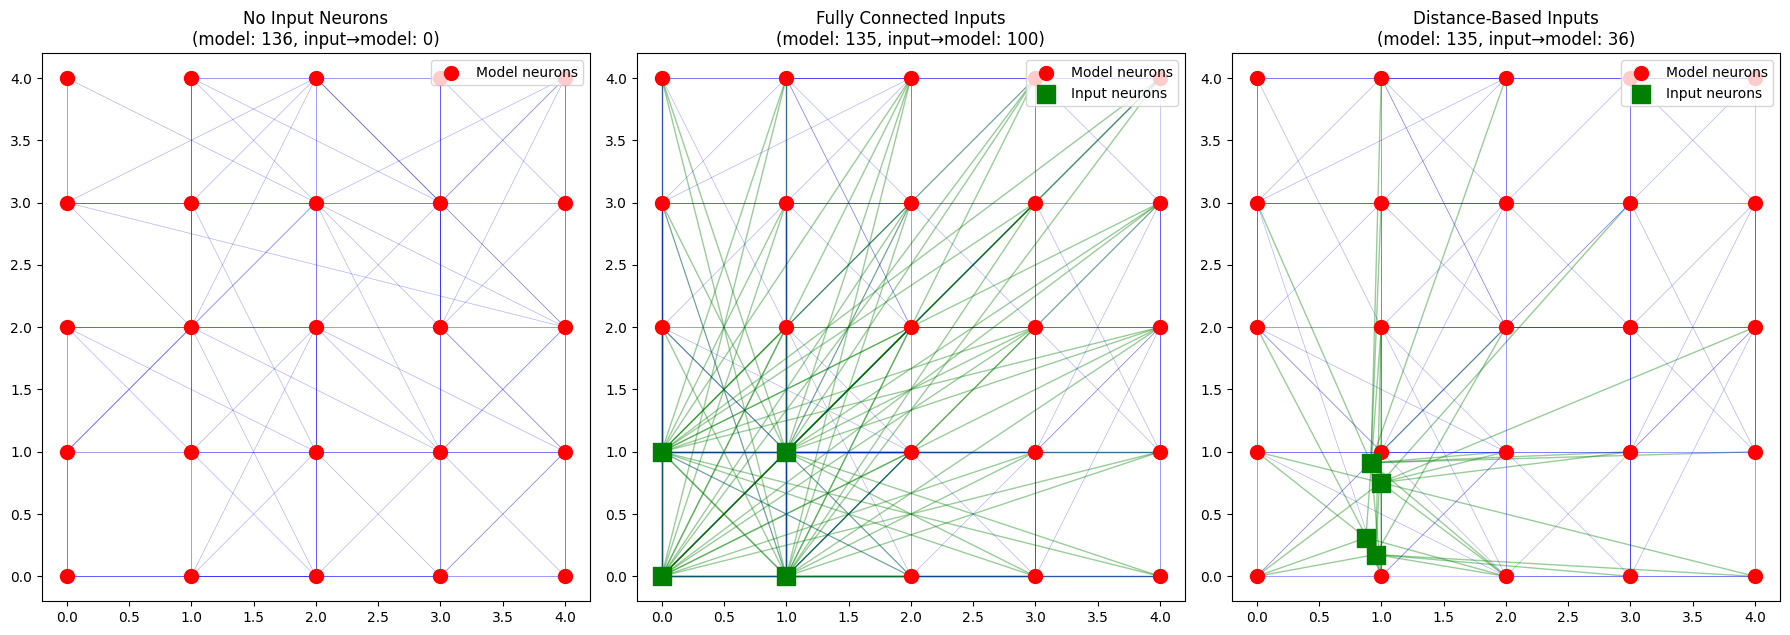

In [9]:
def visualize_network_with_inputs(net, ax=None, title="Network with Inputs"):
    """Visualize a network with distinct input and model neurons."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    input_range = net.ranges.input_range
    model_range = net.ranges.model_range
    
    # Draw connections (input→model in green, model→model in blue)
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            p1 = net.neurons[i].position
            p2 = net.neurons[j].position
            if i in input_range:
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                       'g-', alpha=0.4, linewidth=1)
            else:
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                       'b-', alpha=0.3, linewidth=0.5)
    
    # Draw model neurons (red)
    model_positions = np.array([net.neurons[i].position for i in model_range])
    ax.scatter(model_positions[:, 0], model_positions[:, 1], 
              s=100, c='red', zorder=5, label='Model neurons')
    
    # Draw input neurons (green)
    if len(input_range) > 0:
        input_positions = np.array([net.neurons[i].position for i in input_range])
        ax.scatter(input_positions[:, 0], input_positions[:, 1], 
                  s=150, c='green', marker='s', zorder=6, label='Input neurons')
    
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.legend(loc='upper right')
    return ax

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

configs = [
    ("No Input Neurons", None, None),
    ("Fully Connected Inputs", 
     LatticePositionInitializer(),
     [FullyConnectedInitializer()]),
    ("Distance-Based Inputs",
     RandomPositionInitializer(),
     [DistanceBasedInitializer(GaussianDistanceDistribution(sigma=2))]),
]

for ax, (name, input_pos, input_conn) in zip(axes, configs):
    builder = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_model_initializer(
            neurons=25,
            connections=[DistanceBasedInitializer(GaussianDistanceDistribution(sigma=1.5))],
        )
        .with_seed(42)
    )
    if input_pos is not None:
        builder = builder.with_input_initializer(
            neurons=4,
            position=input_pos,
            connections=input_conn,
        )
    net = builder.build()
    
    input_conns = sum(1 for i in net.ranges.input_range for _ in net.get_outgoing(i))
    model_conns = net.connection_count() - input_conns
    visualize_network_with_inputs(
        net, ax=ax, 
        title=f"{name}\n(model: {model_conns}, input→model: {input_conns})"
    )

plt.tight_layout()
plt.show()